<h1> Objective </h1>
The dataset consists of 10000 individuals and whether their credit card has defaulted or not. 
Predict whether the individual will default in their credit card payment.

# Loading DataSet

In [0]:
#Download dataset
!wget -q https://www.dropbox.com/s/2ru004fjr6q13zm/default.csv

# Importing Modules

In [0]:
#Import basic packages

import warnings
warnings.filterwarnings("ignore")
import time
import pandas as pd               
import numpy as np
import pickle

from sklearn.model_selection import train_test_split   #splitting data
from pylab import rcParams
from sklearn.linear_model import LinearRegression         #linear regression
from sklearn.metrics.regression import mean_squared_error #error metrics
from sklearn.metrics import mean_absolute_error

import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation

%matplotlib inline     
sns.set(color_codes=True)

# Exploaratory Data Analysis

Reading Data

In [3]:
# Read data through Pandas and compute time taken to read

t_start = time.time()
df_credit = pd.read_csv('default.csv')
t_end = time.time()
print('Time to Load Data: {} s'.format(t_end-t_start)) # time [s]
df_credit.head()

Time to Load Data: 0.023564577102661133 s


,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [4]:
#Let's look into the total number of columns and observations in the dataset
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
default    10000 non-null object
student    10000 non-null object
balance    10000 non-null float64
income     10000 non-null float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


In [5]:
#Let's look into summary statistics of data
df_credit.describe()

,balance,income
count,10000.000000,10000.000000
mean,835.374886,33516.981876
std,483.714985,13336.639563
min,0.000000,771.967729
25%,481.731105,21340.462903
50%,823.636973,34552.644802
75%,1166.308386,43807.729272
max,2654.322576,73554.233495


**Statistical Insight Using Pandas profiling**

In [0]:
#Perform Pandas profiling to understand quick overview of columns

import pandas_profiling
report = pandas_profiling.ProfileReport(df_credit)
#covert profile report as html file
report.to_file("credit_data.html")

In [7]:
from IPython.display import display,HTML,IFrame

display(HTML(open('credit_data.html').read()))

Number of variables,4
Number of observations,10000
Total Missing (%),0.0%
Total size in memory,312.6 KiB
Average record size in memory,32.0 B
Numeric,2
Categorical,2
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [8]:
# count the number of NaN values in each column
print(df_credit.isnull().sum())

default    0
student    0
balance    0
income     0
dtype: int64


In [9]:
#The datatypes have now been changed
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
default    10000 non-null object
student    10000 non-null object
balance    10000 non-null float64
income     10000 non-null float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


# Data Visualisation

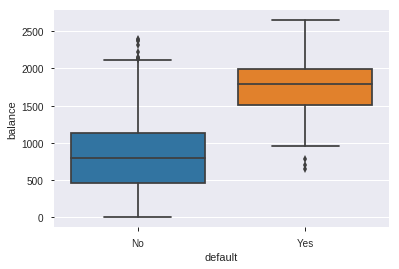

In [10]:
# Relation between balance and default
%matplotlib inline
sns.boxplot(x='default', y='balance', data=df_credit)
plt.show()

**Observation:**
- People who have more balance have defaulted more in their credit card payments.

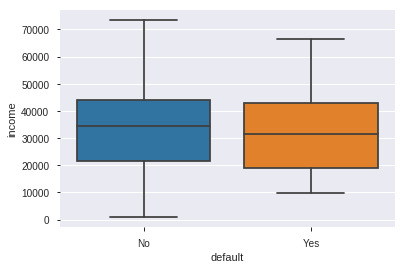

In [11]:
# Relation between income and default

sns.boxplot(x='default', y='income', data=df_credit)
plt.show()

**Observation:** 
- There is not much relation between income and whether they have defaulted in their credit card payments.

In [0]:
#Install Packages

!pip -q install plotly-express

# Code for displaying plotly express plots inline in colab
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))
  
import plotly_express as px

In [13]:
# Relation between balance and income and whether they have defaulted or not
configure_plotly_browser_state()
px.scatter(df_credit, x="income", y="balance" ,color="default",
           hover_data=["student"], log_x=True, size_max=60)

**Observation:**
- People who have more balance have more defaults.

In [14]:
# Relation between Student and default

pd.crosstab(df_credit['default'], df_credit['student'], rownames=['Default'], colnames=['Student'])

Student,No,Yes
Default,,
No,6850,2817
Yes,206,127


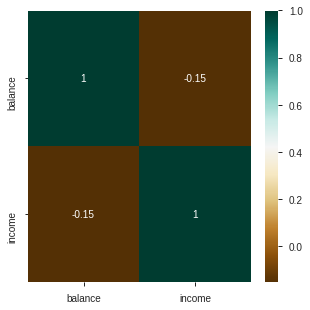

In [15]:
# Correlation between selected variables
plt.figure(figsize=(5,5))
c = df_credit.corr()
sns.heatmap(c,cmap="BrBG",annot=True)

**Observation:**
- The heat map illustrates that income and balance are negatively correlated.

In [16]:
# Explore how often a student defaults
configure_plotly_browser_state()
px.box(df_credit, x="default", y="income", color="student",hover_data=['balance'],notched=True)

**Observation:**

- Student defaulters are lesser as compared to others

# Model Building

In [17]:
#Select the variables to be one-hot encoded
one_hot_features = ['student', 'default']
# Convert categorical variables into dummy/indicator variables (i.e. one-hot encoding).
one_hot_encoded = pd.get_dummies(df_credit[one_hot_features],drop_first=True)
one_hot_encoded.info(verbose=True, memory_usage=True, null_counts=True)

# Convert Categorical to Numerical for default column


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
student_Yes    10000 non-null uint8
default_Yes    10000 non-null uint8
dtypes: uint8(2)
memory usage: 19.6 KB


In [18]:
# Replacing categorical columns with dummies
fdf = df_credit.drop(one_hot_features,axis=1)
fdf = pd.concat([fdf, one_hot_encoded] ,axis=1)
fdf.head()

,balance,income,student_Yes,default_Yes
0,729.526495,44361.625074,0,0
1,817.180407,12106.134700,1,0
2,1073.549164,31767.138947,0,0
3,529.250605,35704.493935,0,0
4,785.655883,38463.495879,0,0


In [19]:
fdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
balance        10000 non-null float64
income         10000 non-null float64
student_Yes    10000 non-null uint8
default_Yes    10000 non-null uint8
dtypes: float64(2), uint8(2)
memory usage: 175.9 KB


**Standardization**

In [0]:
#Standardize rows into uniform scale

X = fdf.drop(['default_Yes'],axis=1)
y = fdf['default_Yes']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)

# Scale and center the data
fdf_normalized = scaler.transform(X)

# Create a pandas DataFrame
fdf_normalized = pd.DataFrame(data=X, index=X.index, columns=X.columns)

**Split the data into train and test**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(fdf_normalized,y,random_state=1234,test_size=0.3)

**Train the model**

In [22]:
# Building the Logistic Regression Model

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1)                            # Set Large C value for low regularization to prevent overfitting
logreg.fit(X_train, y_train)

print(logreg.coef_)                                            # Coefficients for Logistic Regression
print(logreg.intercept_)

[[ 3.95485354e-04 -1.24885098e-04 -2.55369065e-06]]
[-1.99791085e-06]


**Test the model**

In [0]:
# now applying our learnt model on test and also on train data

y_pred_test = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train)

**Accuracy of the model**

In [24]:
from sklearn import metrics
# comparing the metrics of predicted lebel and real label of test data
print("Test Accuracy: ", metrics.accuracy_score(y_test, y_pred_test))

Test Accuracy:  0.9673333333333334


In [25]:
# comparing the metrics of predicted lebel and real label of test data
print("Train Accuracy: ", metrics.accuracy_score(y_train, y_pred_train))

Train Accuracy:  0.966


**Null Accuracy**

In [26]:
# Actual Values of y_test
y_test.value_counts()
y_test.value_counts().head(1) / len(y_test)

0    0.967333
Name: default_Yes, dtype: float64

The null accuracy is **96.67%**. There is only a slight improvement in accuracy for our model from the baseline model.

Accuracy is not an appropriate metric in this scenario. We employ confusion matrix and ROC curve to further understand performance of our model on test data.

**Confusion Matrix**

In [0]:
conf=metrics.confusion_matrix(y_test, y_pred_test)

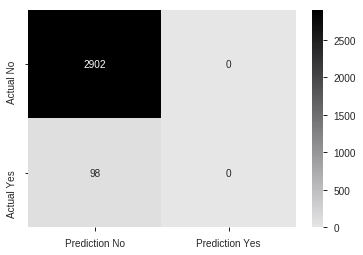

In [28]:
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(conf,cmap = cmap,xticklabels=['Prediction No','Prediction Yes'],yticklabels=['Actual No','Actual Yes'], annot=True,
            fmt='d')

**Observation:**
- Unfortunately, the model has not predicted any of the defaulters correctly.

In [29]:
# Creating Classification Report

cr = metrics.classification_report(y_test, y_pred_test)
print(cr)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2902
           1       0.00      0.00      0.00        98

    accuracy                           0.97      3000
   macro avg       0.48      0.50      0.49      3000
weighted avg       0.94      0.97      0.95      3000



**Imbalanced Data**

The above metrics illustrate there is a clear imbalance in data.

Let us retrain our data using logistic regression this time using a parameter called 'balanced' which would handle imbalance in the data by changing the threshold set by logistic regression model:

In [30]:
# Building the Logistic Regression Model

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e42,class_weight='balanced')                     # Set Large C value for low regularization to prevent overfitting
logreg.fit(X_train, y_train)

print(logreg.coef_)                                                             # Coefficients for Logistic Regression
print(logreg.intercept_)

[[ 5.75767135e-03  1.03398205e-05 -4.23281408e-01]]
[-7.80637608]


**saveing the model**

In [31]:
from sklearn.externals import joblib 
  
# Save the model as a pickle in a file 
joblib.dump(logreg, 'model.pkl') 

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



['model.pkl']

In [0]:
# now applying our learnt model on test and also on train data

y_pred_test = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train)

In [33]:
from sklearn import metrics
# comparing the metrics of predicted lebel and real label of test data
print("Test Accuracy: ", metrics.accuracy_score(y_test, y_pred_test))

Test Accuracy:  0.8693333333333333


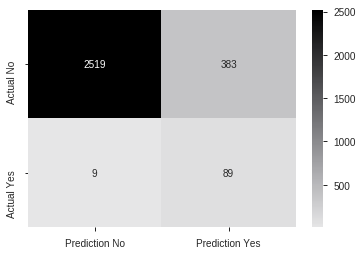

In [34]:
# creating a confusion matrix to understand the classification
conf = metrics.confusion_matrix(y_test, y_pred_test)
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(conf,cmap = cmap,xticklabels=['Prediction No','Prediction Yes'],yticklabels=['Actual No','Actual Yes'], annot=True,
            fmt='d')

In [35]:
# Creating Classification Report

cr = metrics.classification_report(y_test, y_pred_test)
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.87      0.93      2902
           1       0.19      0.91      0.31        98

    accuracy                           0.87      3000
   macro avg       0.59      0.89      0.62      3000
weighted avg       0.97      0.87      0.91      3000



**ROC Curve**

In [0]:
predict_probabilities = logreg.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predict_probabilities[:,1])

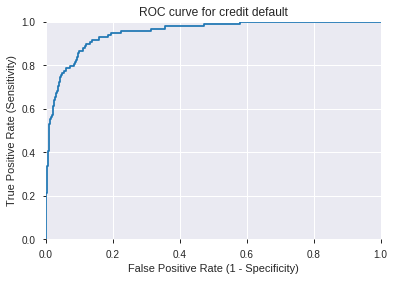

In [37]:
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for credit default')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)